# 2.3. (Mouse) Quality control of the differential expression analysis
 
## Input

* Files within the folder `data-create_networks/mouse/comparisons/`: results of the DEA for the comparisons.
* `data-create_networks/mouse/yeast_WT_logCPM.txt`: normalized counts in log CPM.

## Output

* Figures:
    * Distribution of raw p-values
    * Distribution of log fold-changes of DEGs
    * Volcano plots
    * Number of DEGs shared across comparisons
    * Ratio of DEGs within each comparison
    * Jaccard similarity of DEGs between the comparisons

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

In [2]:
sns.set(style="whitegrid", context="talk", rc={"figure.figsize": (8,5)})

In [3]:
fdrCut = 0.05
results_folder = '../../../data-create_networks/mouse/comparisons/'

In [4]:
comparison_files = sorted(glob.glob(results_folder + '*'))

percentage_degs = []
significant_genes = []
comparisons = []
names = []

for file in comparison_files:
    data = pd.read_csv(file, sep='\t', index_col=0)
    name = file.split('/')[-1].split('.')[0].split('_')[-1]
    comparisons.append( data )
    names.append( name )
    
    sig = data[data['FDR'] <= fdrCut]
    significant_genes.append( set( sig.index.tolist() ) )
    
    percentage_degs.append([ name, len(sig), 100*len(sig)/len(data) ])

percentage_degs = pd.DataFrame(percentage_degs).set_index(0)

In [5]:
pairwise = pd.concat( comparisons, axis=1, keys=names, names=['comparison','value'] )

## Distribution of raw p-values

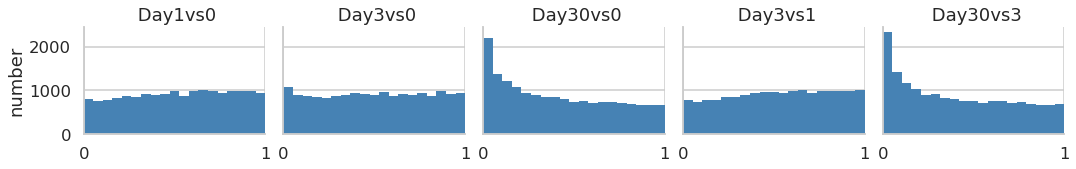

In [6]:
data = pairwise.xs('PValue', level='value', axis=1).unstack().reset_index()

g = sns.FacetGrid(data, col="comparison", col_wrap=5)
g.map(plt.hist, 0, color="steelblue", bins=np.linspace(0, 1, 20), linewidth=0)

g.set( xlim=(0, 1), xticks=[0, 1] )
g.set_ylabels( 'number' )
g.set_xlabels( '' )
g.fig.subplots_adjust( wspace=.1, hspace=.2 )

for ax in g.axes.flat: ax.set_title( ax.get_title().split('=')[1] )

## Distribution of logFC of DEGs

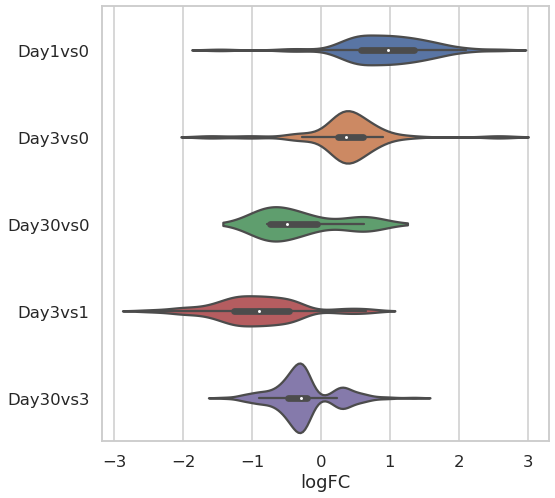

In [7]:
# stack genotype and comparisons levels
data = pairwise.stack(level=0).reset_index()
# select DEGs
data = data.apply(lambda x: x.mask(data['FDR'] > 0.05) if x.name == 'logFC' else x
                 ).sort_values(by="FDR")
# order comparisons
data = pd.concat([
    data.query(f" comparison == '{c}'  ")
    for c in pairwise.columns.get_level_values(level='comparison')
])

# plot
fig, ax = plt.subplots(figsize=(8,8))
g = sns.violinplot( data=data, y='comparison', x='logFC', ax=ax )
g.set_ylabel('')
plt.show()

## Volcano plots

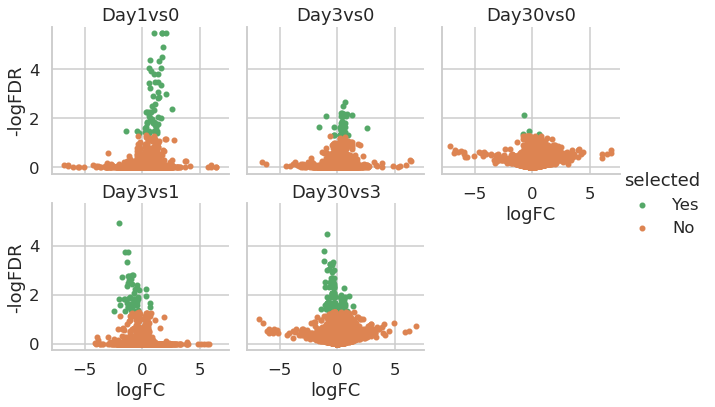

In [8]:
# rename comparisons to order them
data = pairwise.copy()
comp = data.columns.get_level_values(level=0).unique()
data.columns = data.columns.set_levels( range(len(comp)), level=0 )
# stack genotype and comparisons levels
data = data.stack(level=0).reset_index()
# add a tag to DEGs
data['selected'] = (data['FDR'] <= fdrCut).replace({False: 'No', True: 'Yes'})
# convert FDR into log FDR
data['FDR'] = data['FDR'].apply(lambda x: -np.log10(x))

# plot
colors = sns.color_palette("deep", 6).as_hex()
pal = {'Yes': colors[2], 'No': colors[1]}

g = sns.FacetGrid( data, col='comparison', col_wrap=3,
                   hue='selected', hue_order=['Yes', 'No'],
                   palette=pal, margin_titles=True )
g.map(plt.scatter, 'logFC', 'FDR', marker=".").add_legend()

#g.set( xlim=(-10, 10), ylim=(0, 5),
#       xticks=[-5, 0, 5], yticks=[0, 2, 4] )
g.set_ylabels( '-logFDR' )
g.fig.subplots_adjust( wspace=.1, hspace=.2 )

for i, ax in enumerate(g.axes.flat):
    # Make title more human-readable
    if ax.get_title(): ax.set_title(comp[i]) #ax.set_title( ax.get_title().split('=')[1] )
    # Change margin titles (Only right axes have something in ax.texts)
    if ax.texts:
        # This contains the right ylabel text
        txt = ax.texts[0]
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                txt.get_text().split('=')[1],
                transform=ax.transAxes,
                va='center')
        # Remove the original text
        ax.texts[0].remove()

## Number of DEGs shared across comparisons

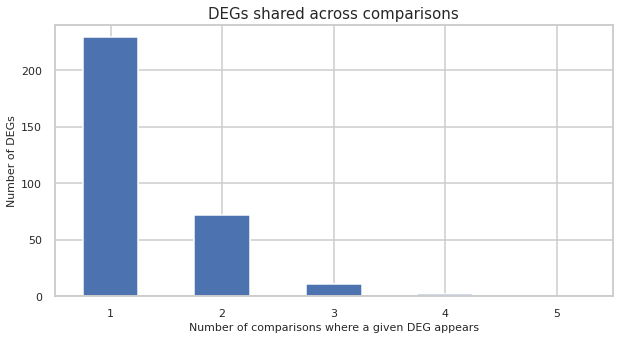

In [9]:
df = pairwise.xs('FDR', level='value', axis=1)

i, y = 0, []
while not y or y[-1] != 0:
    y.append( ( (df <= fdrCut).sum(axis=1) > i ).sum() )
    i += 1
    
ax = pd.Series(y, index=range(1,len(y)+1)).plot.bar(figsize=(10,5), fontsize=11, )

# other features
plt.ylabel( 'Number of DEGs', fontsize=11 )
plt.xlabel( 'Number of comparisons where a given DEG appears', fontsize=11 )
plt.title( 'DEGs shared across comparisons', fontsize=15 )
plt.xticks(rotation=0)
#plt.savefig( '../time-course_exp/degs_shared_across_comparisons.png', bbox_inches='tight', dpi=300 )
plt.show()

## % of DEGs in each comparison

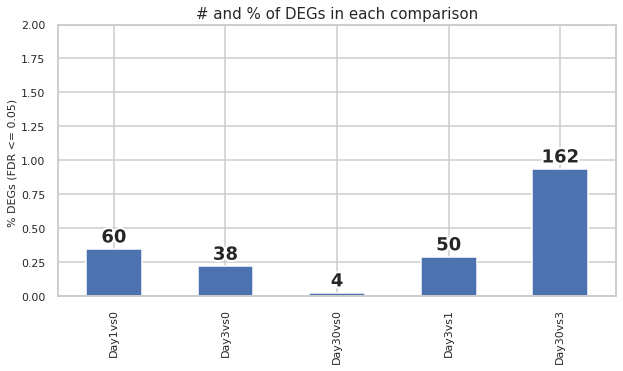

In [10]:
ax = percentage_degs[2].plot.bar(figsize=(10,5), fontsize=11)

# add number of observations
bars = [ ( p.get_x(), p.get_width(), p.get_height() ) for p in ax.patches ]
for i in range(len(percentage_degs)):
    txt = plt.text(x = bars[i][0] + 0.25, y = bars[i][2] + .05,
                   s = percentage_degs.iloc[i,0],
                   horizontalalignment = 'center',
                   fontdict = { 'fontweight':'bold' } )
    txt.set_path_effects([ PathEffects.withStroke( linewidth=4, foreground='w' ) ])
    
# other features
plt.ylabel( f'% DEGs (FDR <= {fdrCut}) ', fontsize=11 )
plt.xlabel( None )
plt.ylim( [0,2] )
plt.title( '# and % of DEGs in each comparison', fontsize=15 )
#plt.savefig( '../time-course_exp/percentage_of_degs_for_comparisons.png', bbox_inches='tight', dpi=300 )
plt.show()

## Jaccard similarity between conditions

In [11]:
jaccard_similarity = pd.Series(dtype=np.float64)
for i in range( 0, len(names)-1 ):
    a, b = significant_genes[i], significant_genes[i+1]
    if len(a) + len(b) > 0: sim = 100 * len(a & b) / ( len(a) + len(b) - len(a & b) )
    else: sim = 0
    jaccard_similarity[ names[i] + ' <> ' + names[i+1] ] = sim

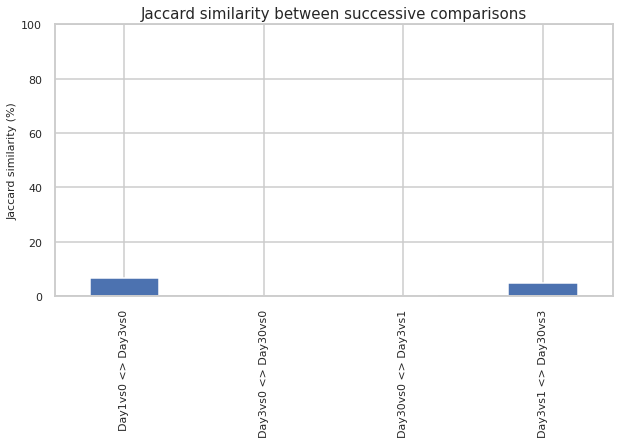

In [12]:
jaccard_similarity.plot.bar( figsize=(10,5), fontsize=11 )
plt.ylabel( 'Jaccard similarity (%)', fontsize=11 )
plt.ylim([0,100])
plt.title( 'Jaccard similarity between successive comparisons', fontsize=15 )
#plt.savefig( '../time-course_exp/jaccard_similarity_between_comparisons.png', bbox_inches='tight', dpi=300 )
plt.show()